# Data analysis interview take-home challenge

In [196]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Part 1 ‐ Exploratory data analysis

In [197]:
df_login = pd.read_json('logins.json', orient='columns')

In [198]:
df_login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [199]:
df_login.set_index('login_time', inplace=True)

In [200]:
df_login['count'] = 1

In [201]:
# Aggregate the data into 15-minute intervals
df_15min = df_login.resample('15T').sum()

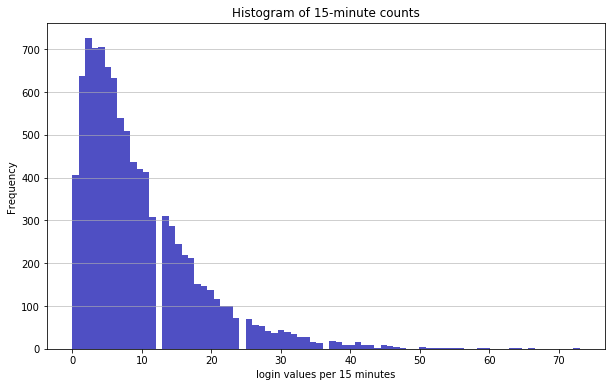

In [202]:
# Histogram
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=df_15min['count'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=1)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('login values per 15 minutes')
plt.ylabel('Frequency')
plt.title('Histogram of 15-minute counts')
plt.show()

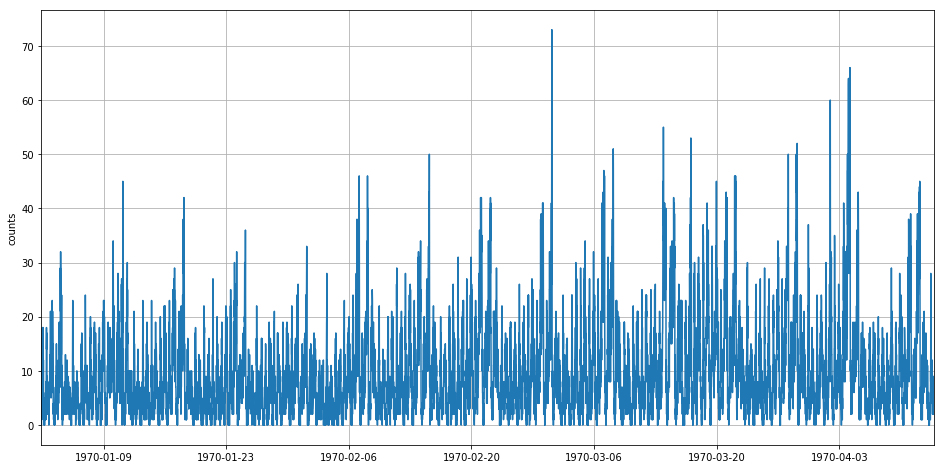

In [203]:
plt.figure(figsize=(16,8))
plt.plot(df_15min)
plt.xlim([df_15min.index[0], df_15min.index[-1]])
plt.ylabel('counts')
plt.grid()
plt.show()

In [204]:
# Group the data by the index's hour value, then aggregate by the average
df_hourly = df_login.groupby(df_login.index.hour).sum()

In [205]:
x = list(range(0, 24))

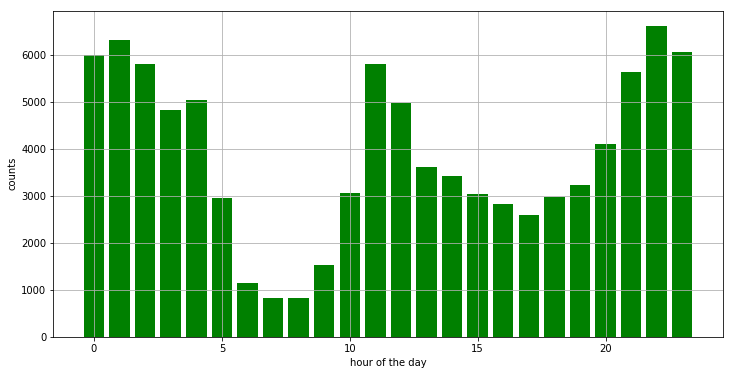

In [206]:
plt.figure(figsize=(12,6))
plt.bar(x = x, height=df_hourly['count'], color='g')
plt.xlabel('hour of the day')
plt.ylabel('counts')
plt.grid()
plt.show()

### Findings

* From the aggregated 15-minute data, the distribution is skewed (not normally distributed), i.e., with login counts heavily concentrated at the lower end, and some occasional high number of logins per 15 minutes. 
* The data is cyclical, with more logins during certain time of the day.
* By grouping the data further, it can be seen that there are indeed peak times of the day: around lunch time (between 11:00 and 12:00), and around night time (between 20:00 and 04:00). 

## Part 2 - Experiment and metrics design

__Q1__. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

__Answer:__

The chosen metric would be the proportion of driver partners that appear at each city before and after the introduction of reimbursing the toll costs. Specifically, compare the proportion of Gotham driver partners that appear in the city of Metropolis, and also compare the proportion of Metropolis driver partners that appear in the city of Gotham, before and after the change of toll costs. 

The reason is simple---if reimbursing the toll costs had no effect, then these proportions would stay more or less the same. If it does have an effect, we would see an increase of driver partners at the other city. 

__Q2__. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the
observation

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

__Answer:__

__a:__ The experiment will be divided into two parts: one in the first month (before reimbursement happens), the other in the second month (after reimbursement happens). In both months, for each city, log the number of driver partners from Gotham and Metropolis respectively. Then, calculate the proportion of Gotham driver partners that appear in Metropolis, let's denote the proportion in the first month G1, and the proportion in the second month G2; also calculate the proportion of Metropolis driver partners that appear in Gotham M1 in the first month, and M2 in the second month. 

<div class="span5 alert alert-success">
<p> $b:$ 
    
Two hypothesis tests will be carried out.

(1)
<p>$H_o$: $G_1 = G_2$ </p>
<p>$H_A$: $G_1\neq G_2$ </p>

(2)
<p>$H_o$: $M_1 = M_2$ </p>
<p>$H_A$: $M_1\neq M_2$ </p>

<p>Set the significance level $\alpha$ to be 0.05. </p>

</div>

This is a standard two proportion z test. For each hypothesis test, calculate z from the available data (i.e., the observed proportions G1 and G2, and the number of observations n1 and n2). Then calculate the p-value from the z-statistic. So we will obtain two p-values, one for the first hypothesis, and the other for the second hypothesis. 

__c:__ 

The results depend on the p-values. If both p-values turn out to be less than the preset significance level of 0.05, then we can reject the null hypothesis, i.e., we have evidence that by reimbursing the toll costs, the driver partner representation at each city did have a change. __Recommendation__: reduce the toll charge for this bridge in both directions to encourage driver partners to be available in both cities. 

If only one p-value turns out to be less than the preset significance level of 0.05, then we will conclude that the experiment has effect on one city only. __Recommendation__: Option 1: reduce the toll charge in both directions (as did in the experiment). Option 2: reduce the toll charge for this bridge in the direction that we saw an increase in driver partners representation (e.g., if from the experiment we saw an increase of Gotham driver partners in Metropolis, then reduce the toll charge in the direction from Gotham to Metropolis). This may have a further effect when implemented, if Metropolis drivers see no reduction of toll charge in their direction, other incentive may be sought for Metropolis drivers. 

If both p-values are greater than 0.05, we will conclude that the reimbursement made no difference. __Recommendation__: Keep the toll charge as is. Seek other incentives. 

__Caveats__:
The preset significance level of 0.05 is somewhat arbitary, which may be set at a different level, e.g., 0.02. So the results we get from this experiment may carry different weight. For example, if the p-values we obtained are close to 0.05, the decision may not be so clear cut. If the p-values are a lot less than 0.05, say 0.01, then we can be comfortable that we have strong evidence to reject the null hypothesis. 

## Part 3 ‐ Predictive modeling

In [207]:
# read file
with open('ultimate_data_challenge.json', 'r') as myfile:
    data=myfile.read()
    
# parse file
obj = json.loads(data)

In [208]:
df_ultimate = json_normalize(obj)
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Data cleaning and exploratory analysis

In [209]:
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [210]:
# Deal with columns that contail NaN values
# Drop rows with NaN for column phone
df_ultimate.dropna(subset=['phone'], inplace=True)

In [211]:
# For columns avg_rating_by_driver and avg_rating_of_driver, fill NaN rows with average
df_ultimate['avg_rating_of_driver'] = df_ultimate['avg_rating_of_driver'].fillna(df_ultimate['avg_rating_of_driver'].mean())
df_ultimate['avg_rating_by_driver'] = df_ultimate['avg_rating_by_driver'].fillna(df_ultimate['avg_rating_by_driver'].mean())

In [212]:
df_ultimate.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,5.785418,4.777861,4.601467,1.074991,8.875314,2.277256,60.883832
std,5.669709,0.446220,0.565227,0.222666,19.989018,3.793300,37.086239
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000
75%,6.930000,5.000000,5.000000,1.050000,8.700000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [213]:
# The data still doesn't look right, as avg_dist and surge_pct have rows with 0 values
df_ultimate[df_ultimate['avg_dist'] == 0]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
72,0.0,3.000000,5.000000,1.00,Astapor,2014-01-08,iPhone,2014-01-07,0.0,1,False,100.0
116,0.0,5.000000,5.000000,1.00,Winterfell,2014-01-11,Android,2014-01-10,0.0,1,False,100.0
188,0.0,5.000000,4.601467,1.00,Winterfell,2014-01-14,Android,2014-01-11,0.0,1,False,100.0
356,0.0,5.000000,4.000000,1.00,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,False,100.0
479,0.0,5.000000,5.000000,1.00,Winterfell,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
1194,0.0,4.000000,3.000000,1.00,Winterfell,2014-02-07,Android,2014-01-17,0.0,1,False,100.0
1519,0.0,5.000000,5.000000,1.00,Winterfell,2014-01-23,Android,2014-01-22,0.0,1,False,100.0
1524,0.0,5.000000,5.000000,1.00,Winterfell,2014-05-22,iPhone,2014-01-01,0.0,0,False,100.0
1575,0.0,5.000000,4.000000,1.00,Winterfell,2014-01-19,iPhone,2014-01-18,0.0,1,False,0.0
1797,0.0,5.000000,4.601467,1.00,Astapor,2014-01-04,iPhone,2014-01-03,0.0,1,False,100.0


avg_dist is defined as "the average distance in miles per trip taken in the first 30 days after signup". However, in some of the rows with avg_dist = 0, trips_in_first_30_days has value of 1, which are contradictory with each other. So the 0 in avg_dist in these rows must contain missing information.

In [214]:
len(df_ultimate[df_ultimate['avg_dist'] == 0])

149

In [215]:
# We are going to drop these rows
df_ultimate.drop(df_ultimate[(df_ultimate['avg_dist'] == 0) & (df_ultimate['trips_in_first_30_days'] >= 1)]
                      .index, inplace=True)

In [216]:
df_ultimate.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,49511.000000,49511.000000,49511.000000,49511.000000,49511.000000,49511.000000,49511.000000
mean,5.796285,4.778797,4.601658,1.075046,8.885926,2.279615,60.893167
std,5.669479,0.442462,0.564785,0.222571,19.991621,3.796465,37.058007
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.430000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000
50%,3.890000,5.000000,4.800000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.700000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [217]:
# Convert last_trip_date and signup_date to datetime objects
df_ultimate['last_trip_date'] = pd.to_datetime(df_ultimate['last_trip_date'])
df_ultimate['signup_date'] = pd.to_datetime(df_ultimate['signup_date'])

In [218]:
df_ultimate['signup_date'].min()

Timestamp('2014-01-01 00:00:00')

In [219]:
df_ultimate['signup_date'].max()

Timestamp('2014-01-31 00:00:00')

In [220]:
df_ultimate['last_trip_date'].min()

Timestamp('2014-01-01 00:00:00')

In [221]:
df_ultimate['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [222]:
from datetime import datetime

In [223]:
date = datetime.strptime('2014-06-01', '%Y-%m-%d')

In [224]:
date

datetime.datetime(2014, 6, 1, 0, 0)

In [225]:
# we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days, 
# i.e., after 2014-06-01

temp = []
for i in df_ultimate['last_trip_date']:
    if i >= date:
        temp.append(1) # active user
    else:
        temp.append(0)    

In [226]:
df_ultimate['is_active'] = temp

In [227]:
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


__Fraction of users retained is 37.7% (see below).__

In [228]:
active_rate = sum(df_ultimate['is_active'])/len(df_ultimate)
active_rate

0.3770273272606088

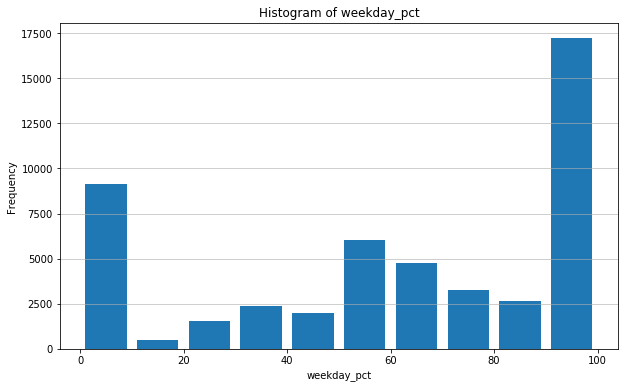

In [229]:
# Histogram
plt.figure(figsize=(10,6))
plt.hist(x=df_ultimate['weekday_pct'], bins = 10, rwidth=0.8)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('weekday_pct')
plt.ylabel('Frequency')
plt.title('Histogram of weekday_pct')
plt.show()

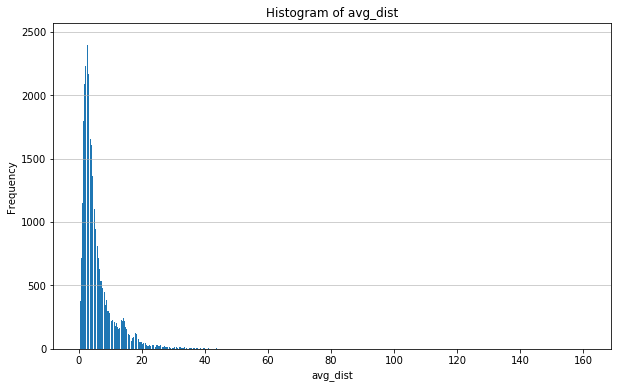

In [230]:
# Histogram
plt.figure(figsize=(10,6))
plt.hist(x=df_ultimate['avg_dist'], bins = 'auto', rwidth=0.8)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('avg_dist')
plt.ylabel('Frequency')
plt.title('Histogram of avg_dist')
plt.show()

__Explore categorical data__

In [231]:
df_ultimate['city'].value_counts()

Winterfell        23068
Astapor           16387
King's Landing    10056
Name: city, dtype: int64

In [179]:
df_ultimate['phone'].value_counts()

iPhone     34525
Android    14986
Name: phone, dtype: int64

In [180]:
df_ultimate['ultimate_black_user'].value_counts()

False    30909
True     18602
Name: ultimate_black_user, dtype: int64

__Visualizing multiple variables with boxplots__

In [181]:
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [182]:
df_ultimate_num = df_ultimate[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
                              'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']]

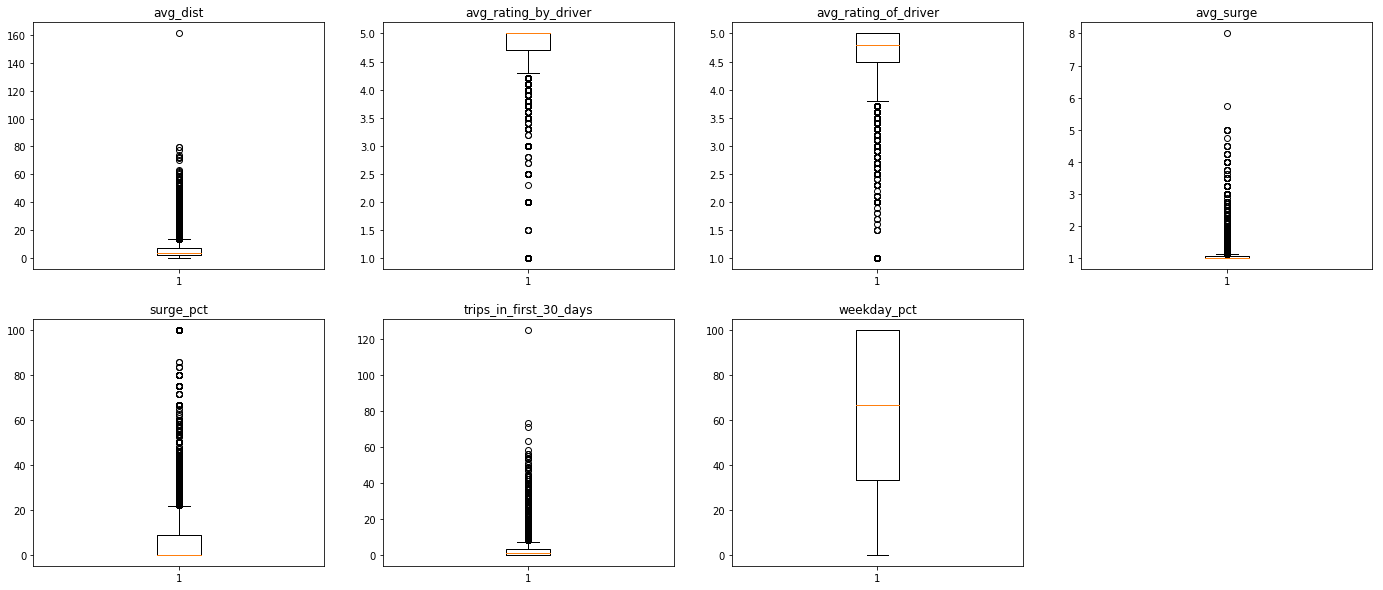

In [183]:
fig = plt.figure(figsize=(24, 10))

plt.subplot(2, 4, 1)
plt.boxplot(df_ultimate_num['avg_dist']);
plt.title('avg_dist');

plt.subplot(2, 4, 2)
plt.boxplot(df_ultimate_num['avg_rating_by_driver']);
plt.title('avg_rating_by_driver');

plt.subplot(2, 4, 3)
plt.boxplot(df_ultimate_num['avg_rating_of_driver']);
plt.title('avg_rating_of_driver');

plt.subplot(2, 4, 4)
plt.boxplot(df_ultimate_num['avg_surge']);
plt.title('avg_surge');

plt.subplot(2, 4, 5)
plt.boxplot(df_ultimate_num['surge_pct']);
plt.title('surge_pct');

plt.subplot(2, 4, 6)
plt.boxplot(df_ultimate_num['trips_in_first_30_days']);
plt.title('trips_in_first_30_days');

plt.subplot(2, 4, 7)
plt.boxplot(df_ultimate_num['weekday_pct']);
plt.title('weekday_pct');

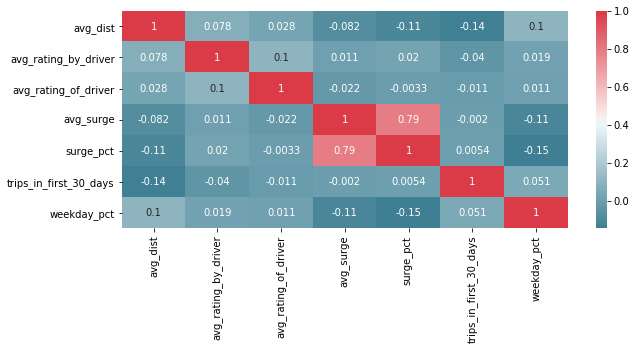

In [184]:
# Check if any numeric columns are highly correlated with each other
corr1 = df_ultimate_num.corr()
# plot the heatmap
fig, ax = plt.subplots(figsize=(10, 4))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1, cmap=colormap, annot=True, xticklabels=corr1.columns, yticklabels=corr1.columns);

In [185]:
# From the above, avg_surge and surge_pct are highly correlated, so drop one of them
df_ultimate.drop(['avg_surge'], axis=1, inplace=True)

In [186]:
df_ultimate_num.drop(['avg_surge'], axis=1, inplace=True)

/Users/Qian/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Build a predictive model

#### 1. Features engineering

In [187]:
print(df_ultimate['signup_date'].min())
print(df_ultimate['signup_date'].max())

2014-01-01 00:00:00
2014-01-31 00:00:00


In [188]:
# There is not much information contained in the signup_date column, so drop it from the dataframe.
df_ultimate.drop(['signup_date'], axis=1, inplace=True)

In [189]:
# Drop the last_trip_date column as well, since we have extracted the info into is_active column.
df_ultimate.drop(['last_trip_date'], axis=1, inplace=True)

In [190]:
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active
0,3.67,5.0,4.7,King's Landing,iPhone,15.4,4,True,46.2,1
1,8.26,5.0,5.0,Astapor,Android,0.0,0,False,50.0,0
2,0.77,5.0,4.3,Astapor,iPhone,0.0,3,False,100.0,0
3,2.36,4.9,4.6,King's Landing,iPhone,20.0,9,True,80.0,1
4,3.13,4.9,4.4,Winterfell,Android,11.8,14,False,82.4,0


__Convert categorical features into numerical values__

In [191]:
from sklearn.preprocessing import LabelEncoder

In [192]:
num = LabelEncoder()

df_ultimate['city'] = num.fit_transform(df_ultimate_cat['city'])
df_ultimate['phone'] = num.fit_transform(df_ultimate_cat['phone'])
df_ultimate['ultimate_black_user'] = num.fit_transform(df_ultimate_cat['ultimate_black_user'])

#### Standardisation

Use the MinMaxScaler, which shrinks the range such that the range is now between 0 and 1, as the data is not quite normally distributed. 

In [50]:
from sklearn import preprocessing

In [51]:
scaler = preprocessing.MinMaxScaler()

In [58]:
# Fit data on the scaler object
scaled = scaler.fit_transform(df_ultimate_num)
df_ultimate_num_scaled = pd.DataFrame(scaled, columns=df_ultimate_num.columns)

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [60]:
df_ultimate_num_scaled.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,trips_in_first_30_days,weekday_pct
count,49511.000000,49511.000000,49511.000000,49511.000000,49511.000000,49511.000000
mean,0.036011,0.944699,0.900415,0.088859,0.018237,0.608932
std,0.035223,0.110616,0.141196,0.199916,0.030372,0.370580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015097,0.925000,0.875000,0.000000,0.000000,0.333000
50%,0.024167,1.000000,0.950000,0.000000,0.008000,0.667000
75%,0.043116,1.000000,1.000000,0.087000,0.024000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [92]:
df_ultimate_cat = df_ultimate[['city', 'phone', 'ultimate_black_user', 'is_active']]

In [93]:
df_ultimate_scaled = pd.concat([df_ultimate_cat, df_ultimate_num], axis=1)

In [94]:
df_ultimate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49511 entries, 0 to 49999
Data columns (total 10 columns):
city                      49511 non-null int64
phone                     49511 non-null int64
ultimate_black_user       49511 non-null int64
is_active                 49511 non-null int64
avg_dist                  49511 non-null float64
avg_rating_by_driver      49511 non-null float64
avg_rating_of_driver      49511 non-null float64
surge_pct                 49511 non-null float64
trips_in_first_30_days    49511 non-null int64
weekday_pct               49511 non-null float64
dtypes: float64(5), int64(5)
memory usage: 4.2 MB


#### Split data into training and testing

In [71]:
from sklearn.model_selection import train_test_split

In [95]:
x = df_ultimate_scaled[['city', 'phone', 'ultimate_black_user', 'avg_dist', 'avg_rating_by_driver',
                       'avg_rating_of_driver', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']]

y = df_ultimate_scaled[['is_active']]

In [96]:
# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(x.values, y.values, random_state=5)                                              

#### Basic approach --- start with Logistic Regression

In [113]:
# Logistic regression definition
logreg = LogisticRegression(solver='sag', max_iter=50)

# Define the parameter grid to be searched from
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Hyperparameter tuning using RandomizedSearchCV
LR_cv = RandomizedSearchCV(logreg, param_grid, cv = 4, scoring = 'neg_log_loss', random_state = 7)

In [114]:
# Fit the model
LR_cv.fit(Xtrain, ytrain.ravel())

# Use the optimised parameters to predict
y_pred_LR = LR_cv.predict(Xtest)

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [115]:
# Predict
y_pred_LR = LR_cv.predict(Xtest)

In [117]:
print('Logistic Regression:')
print(confusion_matrix(ytest, y_pred_LR))
print(classification_report(ytest, y_pred_LR))

Logistic Regression:
[[6549 1121]
 [2804 1904]]
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      7670
           1       0.63      0.40      0.49      4708

   micro avg       0.68      0.68      0.68     12378
   macro avg       0.66      0.63      0.63     12378
weighted avg       0.67      0.68      0.66     12378



### Using Random Forest

In [97]:
RF = RandomForestClassifier()

In [118]:
# 2. Define the parameter grid to be searched from
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]

# Number of features to consider at every split
#max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# 3. Hyperparameter tuning using RandomizedSearchCV
RF_cv = RandomizedSearchCV(RF, random_grid, cv = 4, scoring = 'neg_log_loss', random_state = 7)

In [119]:
RF_cv.fit(Xtrain, ytrain.ravel())

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=7, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=0)

In [120]:
# Predict
y_pred_RF = RF_cv.predict(Xtest)

In [121]:
print('Random Forest:')
print(confusion_matrix(ytest, y_pred_RF))
print(classification_report(ytest, y_pred_RF))

Random Forest:
[[6591 1079]
 [1725 2983]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      7670
           1       0.73      0.63      0.68      4708

   micro avg       0.77      0.77      0.77     12378
   macro avg       0.76      0.75      0.75     12378
weighted avg       0.77      0.77      0.77     12378



<div class="span5 alert alert-success">
<p>Logistic Regression was chosen as the baseline, as it is generally a well-behaved classification algorithm, provided that the features are roughly linear. In our problem, this may not be the case, as we saw earlier in the Exploratory Data Analysis, the features do not seem to be linear. Also the features contain categorical variables, making a mixture with the numeric variables---the combination may be difficult for Logistic Regression to handle. 
    
On the other hand, Random Forest can handle these issues quite well. This is evident in the accuracy score obtained: weighted average of 0.77 (Random Forest) vs 0.66 (Logistic Regression). 
    
The dataset is somehow imbalanced, with about twice the data falling into the 0 class, i.e., the non-active users, than the 1 class, i.e., the active users. The models performed better in predicting the majority class. The neg_log_loss was chosen as the scoring function, which heavily penalises classifiers that are confident about an incorrect classification. This to some degree tackles the imbalanced class problem. In future work, the Class Weight/Importance parameter can be set to finetune the model.     
</p>

</div>

#### Feature importance

In [125]:
# To see the important features
# First need to fit the model with the optimised parameters:
RF_cv.best_params_

{'n_estimators': 80,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 60}

In [126]:
RF_opt = RandomForestClassifier(n_estimators= 80,
 min_samples_split= 10,
 min_samples_leaf= 4,
 max_depth= 60)

RF_opt.fit(Xtrain, ytrain.ravel());

In [132]:
features = df_ultimate.columns[0:-1]
features

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'city',
       'phone', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user',
       'weekday_pct'],
      dtype='object')

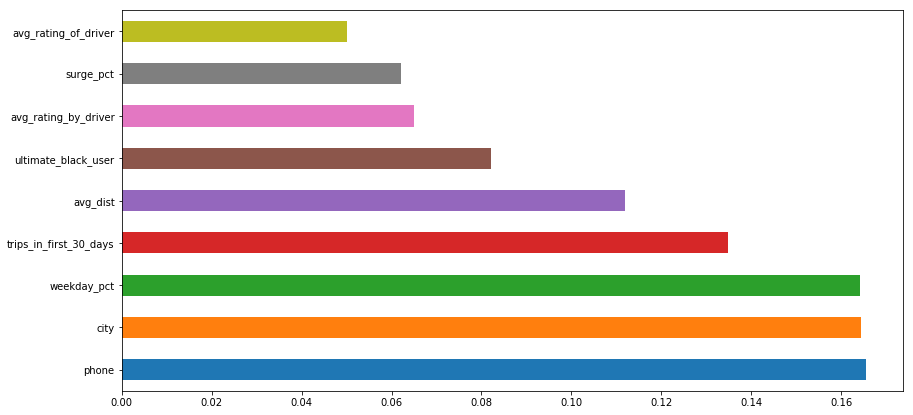

In [134]:
fig = plt.figure(figsize=(14,7))
(pd.Series(RF_opt.feature_importances_, index=features)
   .nlargest(30)
   .plot(kind='barh')) 
plt.show()

In [135]:
df_ultimate_active = df_ultimate_scaled[df_ultimate_scaled.is_active==1]

In [137]:
df_ultimate_active['phone'].value_counts()

1    15521
0     3146
Name: phone, dtype: int64

In [138]:
df_ultimate_active['city'].value_counts()

2    8147
1    6323
0    4197
Name: city, dtype: int64

<div class="span5 alert alert-success">
<p>Recommendations:
    
From the "features importance" graph, we can see that 'phone', 'city' and 'weekday_pct' are the top 3 predictors. Of the phone type, Label 1 correspond to iPhone. It seems that iPhone users tend to be active users 6 months down the track. So one recommendation is to target users who use iPhone, perhaps give them some incentives for the rides, and/or send them some Ulitmate marketing materials for better exposure. 

In general, running the Random Forest algorithm above can predict rider retention to about 77% accuracy. 


</p>

</div>